In [1]:
#!/usr/bin/python
from __future__ import absolute_import

import numpy as np
from tensorflow import keras
import pickle
import argparse
import copy
import random

from shapley.apps import Label
from shapley.loader import FashionMnist, MNIST
from shapley.measures import KNN_Shapley, KNN_LOO, G_Shapley, LOO, TMC_Shapley
from shapley.utils.plotter import LabelPlotter

%matplotlib inline

/home/zidaneandmessi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zidaneandmessi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zidaneandmessi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zidaneandmessi/.local/lib/python3.6/site-packages/tensorflow/

# Noisy Label Detection

##### data loading

In [2]:
num = 1000
loader = FashionMnist(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

###### measure

In [3]:
measure_KNN = KNN_Shapley(K=5)
measure_KNNLOO = KNN_LOO(K=5)
# measure = G_Shapley()
# measure = TMC_Shapley()
# measure = LOO()

##### application

In [4]:
app = Label(X_data, y_data, X_test_data, y_test_data, model_family='NN')

##### run

In [5]:
res_knn = app.run(measure_KNN)
res_knnloo = app.run(measure_KNNLOO)

[0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1
 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1
 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1
 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0
 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0
 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0
 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 1
 1 0 0 0 1 0 1 1 1 0 0 0 

done!
result shown below:
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 

##### visualize

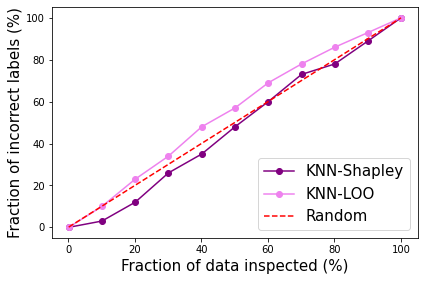

In [8]:
LabelPlotter(app, ('KNN-Shapley',res_knn), ('KNN-LOO',res_knnloo)).plot()

# Pattern-based Watermark Removal

##### data loading

In [ ]:
num = 1000
loader = FashionMnist(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # pattern-based watermark removal

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Instance-based Watermark Removal

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # instance-based watermark removal

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Summarization

##### data loading

In [ ]:
# load UCI Adult dataset

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data summarization

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Data Acquisition

##### data loading

In [ ]:
# load MNIST

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # data acquisition

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED

# Domain Adapatation

##### data loading

In [ ]:
# load two datasets

###### measure

In [ ]:
measure = KNN_Shapley(K=5)

##### application

In [ ]:
app = # domain adaptation

##### run

In [ ]:
# run

##### visualize

In [ ]:
# TO BE COMPLETED